## Week 3: Transfer Learning

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow.keras import layers, optimizers, losses 
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [2]:
training_dataset_url = 'https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip'
validation_dataset_url = 'https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip'

training_dataset_file = tf.keras.utils.get_file(cache_subdir='datasets/horse-or-human/training', 
                                                    origin=training_dataset_url, extract=False)
validation_dataset_file = tf.keras.utils.get_file(cache_subdir='datasets/horse-or-human/validation',
                                                      origin=validation_dataset_url, extract=False)

In [3]:
train_dir = os.path.dirname(training_dataset_file)
validation_dir = os.path.dirname(validation_dataset_file)

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='binary',
    batch_size=32,
    image_size=(150, 150)
).cache().prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    label_mode='binary',
    batch_size=32,
    image_size=(150, 150)
).cache().prefetch(tf.data.AUTOTUNE)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [5]:
model_weights_url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
local_weights_file = tf.keras.utils.get_file(cache_subdir='models', origin=model_weights_url)

In [6]:
def create_pre_trained_model(local_weights_file):
    
    pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                    include_top=False,
                                    weights=None)

    pre_trained_model.load_weights(local_weights_file)
    pre_trained_model.trainable = False

    return pre_trained_model

In [7]:
pre_trained_model = create_pre_trained_model(local_weights_file)

Last layer
```
avg_pool (GlobalAveragePooling2D)  (None, 2048)                                                                                                
predictions (Dense)            (None, 1000)
```

In [8]:
name_layer = 'mixed7'
idx_layer = [layer.name for layer in pre_trained_model.layers].index(name_layer)
print(f'{name_layer} layer is the number {idx_layer+1} with output_shape {pre_trained_model.layers[idx_layer].output_shape}')

# for layer in pre_trained_model.layers[:idx_layer+1]:
#     layer.trainable = False

mixed7 layer is the number 229 with output_shape (None, 7, 7, 768)


In [9]:
print(f'Num layers: {len(pre_trained_model.layers)}')
print(f'Num none trainable layers: {[layer.trainable for layer in pre_trained_model.layers].count(False)}')

Num layers: 311
Num none trainable layers: 311


In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    # layers.RandomTranslation(0, 0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip('horizontal')
])

In [12]:
def create_final_model(pre_trained_model, last_output):
    
    inputs = layers.Input(shape=(150, 150, 3))
    # x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = pre_trained_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    model = tf.keras.Model(inputs, x)

    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                  loss=losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

In [13]:
last_output = pre_trained_model.output
model = create_final_model(pre_trained_model, last_output)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [15]:
callbacks = myCallback()

history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = 20,
                    verbose = 2)

Epoch 1/20
33/33 - 13s - loss: 0.6430 - accuracy: 0.5998 - val_loss: 0.4667 - val_accuracy: 0.7656 - 13s/epoch - 400ms/step
Epoch 2/20
33/33 - 2s - loss: 0.2786 - accuracy: 0.8851 - val_loss: 0.2543 - val_accuracy: 0.8906 - 2s/epoch - 69ms/step
Epoch 3/20
33/33 - 2s - loss: 0.1438 - accuracy: 0.9572 - val_loss: 0.1432 - val_accuracy: 0.9766 - 2s/epoch - 69ms/step
Epoch 4/20
33/33 - 2s - loss: 0.0839 - accuracy: 0.9854 - val_loss: 0.0862 - val_accuracy: 0.9883 - 2s/epoch - 68ms/step
Epoch 5/20
33/33 - 2s - loss: 0.0553 - accuracy: 0.9912 - val_loss: 0.0564 - val_accuracy: 0.9961 - 2s/epoch - 69ms/step
Epoch 6/20
33/33 - 2s - loss: 0.0400 - accuracy: 0.9932 - val_loss: 0.0400 - val_accuracy: 1.0000 - 2s/epoch - 68ms/step
Epoch 7/20
33/33 - 2s - loss: 0.0309 - accuracy: 0.9942 - val_loss: 0.0302 - val_accuracy: 1.0000 - 2s/epoch - 69ms/step
Epoch 8/20
33/33 - 2s - loss: 0.0247 - accuracy: 0.9942 - val_loss: 0.0240 - val_accuracy: 1.0000 - 2s/epoch - 69ms/step
Epoch 9/20
33/33 - 2s - loss:

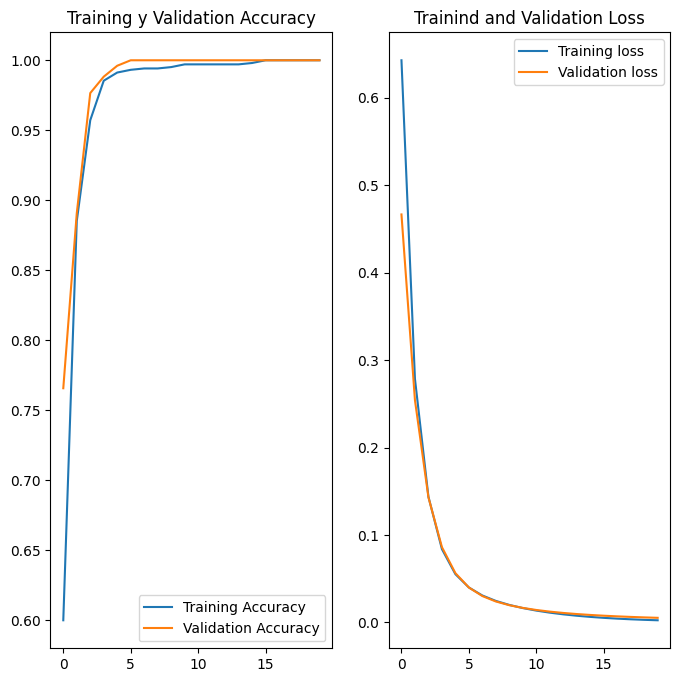

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training y Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Trainind and Validation Loss')
plt.show()